**Install and import dependencies**


In [4]:
from obspy import read
import matplotlib.pyplot as plt
import torch
from preprocessing import to3dArray, pad_or_crop_3d_array

**Ensure CUDA is enabled for hardware accelerated training**

In [2]:
from warnings import warn
if not torch.cuda.is_available():
    warn("No hardware acceleration is being used. Install CUDA or ensure the runtime type is set to GPU if using google colab")
else:
    print("Torch with CUDA is enabled")

Torch with CUDA is enabled


**Replace SGY_PATH with the path to the SEGY file in the mounted google drive account**

In [18]:
SGY_PATH = "./SeismicData/Dixondale.sgy"

stream = read(SGY_PATH, format="SEGY")



# for trace in stream:
#     trace.normalize()
# seismic_array = to3dArray(stream)

In [81]:
print(stream)

125538 Trace(s) in Stream:

Seq. No. in line:    0 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.448000Z | 500.0 Hz, 225 samples
...
(125536 other traces)
...
Seq. No. in line:    0 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.448000Z | 500.0 Hz, 225 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [150]:
sample_depth = len(stream[0].data)


def get_xy(trace):
    header = trace.stats.segy.trace_header
    x_bytes = header.unpacked_header[73:76]
    y_bytes = header.unpacked_header[77:80]
    return int.from_bytes(x_bytes, byteorder="<" if header.endian=="little" else "big"), int.from_bytes(y_bytes, byteorder="<" if header.endian=="little" else "big")


print(get_xy(stream[0]))


(1799239, 263296)


**Normalize all amplitude values from -1 to 1 for model interpretation**

**Calculate number of inlines and crosslines measured**

**Convert into Numpy array with axes as (depth, crossline, inline)**

Text(0, 0.5, 'Depth')

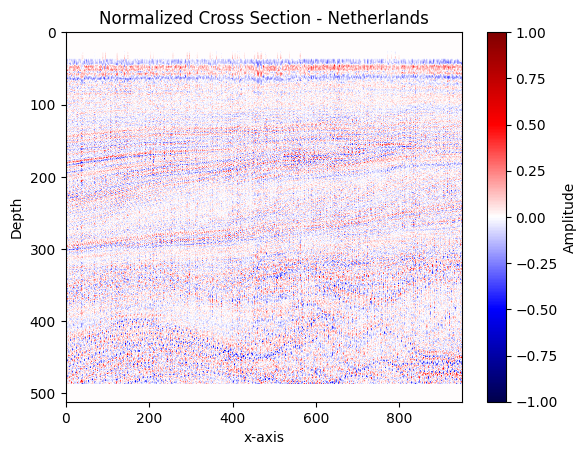

In [7]:

cube = pad_or_crop_3d_array(seismic_array, (512, 512, 512))


example_inline_number = int(len(cube)/2)

plt.imshow(cube[example_inline_number], cmap="seismic", aspect="auto")
plt.colorbar(label="Amplitude")
plt.title("Normalized Cross Section - Netherlands")
plt.xlabel("x-axis")
plt.ylabel("Depth")

In [ ]:
import torch.nn as nn


class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d
        